
# Face Mask Detection – Komplettes Notebook-Gerüst 
# Ein CNN-Modell, mehrfach parametrisiert
# Datensatz: kagglehub "ashishjangra27/face-mask-12k-images-dataset"





### **Setup & Imports**
This cell imports all the necessary Python libraries used throughout the notebook for:
- TensorFlow and Keras for deep learning
- Numpy for numerical operations
- Matplotlib for visualizations
- Scikit-learn for evaluation metrics
- Local custom modules for Kaggle authentication and downloading
It also prints the TensorFlow version.

In [17]:
# 0) Setup & Imports
import os, pathlib, math, random, shutil, json

import creds
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


#### **Path Setup**
Sets up path variables for easier access to directories:
- `NB_DIR`: Notebook directory
- `PROJECT_ROOT`: One level above
- `DATA_ROOT`: The main dataset folder

In [18]:
# 1) Pfade definieren
NB_DIR = pathlib.Path.cwd()
PROJECT_ROOT = NB_DIR.parent
DATA_ROOT = PROJECT_ROOT / "data"

### **Load Kaggle API Key & Download Dataset**
Loads Kaggle API credentials from a local `kaggle.json` file. This is required to authenticate and download datasets using the Kaggle API. If the dataset isn't already present, it will be downloaded and extracted into `data/Train`, `data/Validation`, and `data/Test` folders.

In [19]:
# 2) kaggle.json laden
kaggle_settings_path = NB_DIR / "kaggle.json"
if not kaggle_settings_path.exists():
    raise FileNotFoundError(f"kaggle.json nicht gefunden: {kaggle_settings_path}")

with open(kaggle_settings_path, "r") as f:
    creds = json.load(f)

os.environ["KAGGLE_USERNAME"] = creds["username"]
os.environ["KAGGLE_KEY"] = creds["key"]

# 3) Download nur, wenn Train-Ordner fehlt
if not (DATA_ROOT / "Train").exists():
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    print("Starte Download des Face-Mask-Datasets mit KaggleHub …")

    # Liefert den entpackten Dataset-Ordner im lokalen Cache!
    dataset_root = pathlib.Path(
        kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
    )

    # In diesem Ordner liegt bereits „Face Mask Dataset/Train …“
    SRC = dataset_root / "Face Mask Dataset"

    import shutil

    for split in ["Train", "Validation", "Test"]:
        dst = DATA_ROOT / split
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(SRC / split, dst)

    print("Download abgeschlossen. Ordner Train/Validation/Test erstellt.")
else:
    print("Train/Validation/Test existieren bereits – Download übersprungen.")

print("Dataset liegt unter:", DATA_ROOT)


Train/Validation/Test existieren bereits – Download übersprungen.
Dataset liegt unter: D:\Wichtig\FH\fhcw-se-master\SEM2\AI\Face-Mask-Detection-\data


### **Set Directories and Parameters**
Defines key parameters used in image loading and processing:
- `IMG_SIZE`: The target size of all input images (128x128)
- `BATCH_SIZE`: Number of samples per batch
- `SEED`: Ensures consistency when shuffling data
Also sets up the file paths for training, validation, and test directories.

In [20]:
# 2) Verzeichnisse setzen – Struktur: Train / Validation / Test
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = DATA_ROOT / "Train"
val_dir = DATA_ROOT / "Validation"
test_dir = DATA_ROOT / "Test"

### **Image Loading**
Loads images from the dataset folders using `tf.keras.utils.image_dataset_from_directory`.
Each dataset (Train, Validation, Test) is loaded with consistent batch size and image dimensions. The class names are extracted from folder structure and printed.

In [21]:
# 3) Daten laden
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print("Klassen:", class_names)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Klassen: ['WithMask', 'WithoutMask']


###  **Data Visualization**
This cell displays a sample of 9 images from the training dataset (train_ds) along with their corresponding labels ("WithMask" or "WithoutMask"). The images are arranged in a 3x3 grid using matplotlib.

Key Steps:
- A figure is created with a size of 6x6 inches.
- The take(1) method retrieves the first batch of images and labels from train_ds.
- For each of the first 9 images in the batch:
- The image is displayed using imshow.
- The title of each subplot is set to the corresponding class name.
- Axis labels are turned off for clarity.

Purpose:
- Provides a visual overview of the dataset.
-Helps verify that the data has been loaded correctly and that the labels match the images.

Output:
A grid of 9 images with their respective labels, giving an initial sense of the dataset's content.

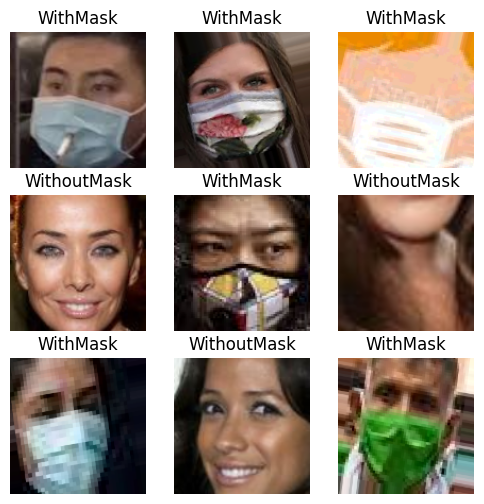

In [22]:
# 3.1) Beispielbilder anzeigen
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### Data Preprocessing
This section defines a **data augmentation** pipeline using TensorFlow Keras. Data augmentation is used to improve model generalization by applying random transformations to training images.

In [23]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

## Model Factory: `build_cnn(...)`

This function builds and compiles a customizable convolutional neural network (CNN) using Keras.

### Parameters
- `conv_blocks`: Number of convolution + pooling blocks (default: 2)
- `dense_units`: Number of units in the dense (fully connected) layer (default: 64)
- `learning_rate`: Learning rate for the Adam optimizer (default: 0.001)

### Architecture
- Input: RGB image of shape `IMG_SIZE + (3,)`
- Data augmentation layer
- Rescaling of pixel values to the [0, 1] range
- Repeated convolution + max-pooling blocks
- Flatten layer
- Dense hidden layer
- Output layer with softmax activation

### Output
Returns a compiled `keras.Model` ready for training:
- Loss: `sparse_categorical_crossentropy`
- Optimizer: Adam
- Metric: Accuracy


In [24]:
# 5) Modell-Fabrik
def build_cnn(conv_blocks=2, dense_units=64, learning_rate=1e-3):
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1. / 255)(x)

    for i in range(conv_blocks):
        x = layers.Conv2D(32 * (i + 1), 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    outputs = layers.Dense(len(class_names), activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Pretrained Model Factory: `build_mobilenetv2(...)`

This function builds a classification model based on a frozen **MobileNetV2** backbone with custom dense layers on top. It leverages pretrained ImageNet weights for efficient transfer learning.

### Parameters
- `dense_units`: Number of units in the custom dense layer (default: 64)
- `learning_rate`: Learning rate for the Adam optimizer (default: 0.001)

### Architecture Overview
- **Base model**: MobileNetV2 (pretrained on ImageNet, without top classifier)
- **Preprocessing**:
  - Data augmentation
  - `mobilenet_v2.preprocess_input` for input normalization
- **Top layers**:
  - Global average pooling
  - Dense hidden layer
  - Final softmax classification layer

### Notes
- The MobileNetV2 layers are **frozen** (`trainable = False`) to prevent updating pretrained weights during training.
- Ideal for fast training and good performance on smaller datasets.

### Output
Returns a compiled `keras.Model`:
- Loss: `sparse_categorical_crossentropy`
- Optimizer: Adam
- Metric: Accuracy


In [25]:
def build_mobilenetv2(dense_units=64, learning_rate=1e-3):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False  # freeze pretrained layers

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # required preprocessing
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    outputs = layers.Dense(len(class_names), activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


## Hyperparameter Variants

This dictionary defines different model configurations for experimentation. Each variant includes key hyperparameters for building and training a specific model type.

### Structure
Each entry includes:
- `type`: Model architecture to use (`"cnn"` or `"mobilenet"`)
- `conv_blocks`: Number of convolution blocks (only for CNNs)
- `dense_units`: Units in the dense layer
- `learning_rate`: Learning rate for the optimizer
- `epochs`: Number of training epochs

### Defined Variants
- **A_small**: A lightweight CNN with 2 conv blocks and 8 epochs
- **B_medium**: A lightweight CNN with 3 conv blocks and 12 epochs
- **C_large**: A lightweight CNN with 4 conv blocks and 15 epochs
- **D_mobilenet_small**: A MobileNetV2-based model with a custom dense head and 8 epochs
- **E_mobilenet_medium**: A MobileNetV2-based model with a custom dense head and 12 epochs
- **F_mobilenet_large**: A MobileNetV2-based model with a custom dense head and 15 epochs

Other variants (e.g., `"B_medium"`, `"C_large"`) are included in comments and can be activated for further testing.


In [26]:
# 6) Hyperparameter-Varianten
VARIANTS = {
    "A_small": {"type": "cnn", "conv_blocks": 2, "dense_units": 64, "learning_rate": 1e-3, "epochs": 8},
    "B_medium": {"type": "cnn", "conv_blocks": 3, "dense_units": 128, "learning_rate": 5e-4, "epochs": 12},
    "C_large":  {"type": "cnn", "conv_blocks": 4, "dense_units": 128, "learning_rate": 1e-4, "epochs": 15},
    "D_mobilenet_small": {"type": "mobilenet", "dense_units": 64, "learning_rate": 1e-3, "epochs": 8},
    "E_mobilenet_medium": {"type": "mobilenet", "dense_units": 128, "learning_rate": 5e-4, "epochs": 12},
    "F_mobilenet_large": {"type": "mobilenet", "dense_units": 128, "learning_rate": 1e-4, "epochs": 15}
}

histories, models = {}, {}

## Training Loop for Variants

This loop iterates over the defined model variants in `VARIANTS` and trains each one based on its configuration.

### Process Overview
- For each variant:
  - Print the variant name
  - Select the appropriate model-building function:
    - `build_mobilenetv2` for MobileNet-based models
    - `build_cnn` for CNN-based models
  - Pass hyperparameters such as `dense_units`, `conv_blocks`, and `learning_rate`
  - Train the model using `model.fit` with specified `epochs`
  - Store the training `history` and the trained `model` in dictionaries for later use

### Outputs
- `histories`: Stores the training history for each variant
- `models`: Stores the trained model instances


In [27]:
for name, params in VARIANTS.items():
    print(f"\n=== Training variant {name} ===")

    if params["type"] == "mobilenet":
        model = build_mobilenetv2(
            dense_units=params["dense_units"],
            learning_rate=params["learning_rate"]
        )
    else:
        model = build_cnn(
            conv_blocks=params["conv_blocks"],
            dense_units=params["dense_units"],
            learning_rate=params["learning_rate"]
        )
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=params["epochs"],
        verbose=2,
    )
    histories[name] = history
    models[name] = model


=== Training variant A_small ===
Epoch 1/8
313/313 - 37s - 118ms/step - accuracy: 0.9167 - loss: 0.2444 - val_accuracy: 0.9750 - val_loss: 0.0875
Epoch 2/8
313/313 - 37s - 117ms/step - accuracy: 0.9566 - loss: 0.1166 - val_accuracy: 0.9837 - val_loss: 0.0592
Epoch 3/8
313/313 - 37s - 118ms/step - accuracy: 0.9677 - loss: 0.0888 - val_accuracy: 0.9900 - val_loss: 0.0287
Epoch 4/8
313/313 - 36s - 115ms/step - accuracy: 0.9752 - loss: 0.0706 - val_accuracy: 0.9875 - val_loss: 0.0314
Epoch 5/8
313/313 - 36s - 116ms/step - accuracy: 0.9770 - loss: 0.0634 - val_accuracy: 0.9837 - val_loss: 0.0390
Epoch 6/8
313/313 - 36s - 114ms/step - accuracy: 0.9774 - loss: 0.0634 - val_accuracy: 0.9900 - val_loss: 0.0236
Epoch 7/8
313/313 - 36s - 115ms/step - accuracy: 0.9801 - loss: 0.0543 - val_accuracy: 0.9925 - val_loss: 0.0166
Epoch 8/8
313/313 - 36s - 115ms/step - accuracy: 0.9812 - loss: 0.0530 - val_accuracy: 0.9925 - val_loss: 0.0230

=== Training variant B_medium ===
Epoch 1/12
313/313 - 46s - 

## Selecting the Best Model Variant

This code identifies the best-performing model variant based on validation accuracy.

### Process
- Iterates through all training histories stored in `histories`
- Finds the variant with the highest recorded validation accuracy (`val_accuracy`)
- Retrieves the corresponding trained model from `models`
- Prints the name of the best variant

### Outputs
- `best_name_cnn`: The name of the variant with the highest validation accuracy of the CNN models
- `best_model_cnn`: The trained model instance corresponding to `best_name_cnn`
- `best_name_mobilenet`: The name of the variant with the highest validation accuracy of the MobileNet models
- `best_model_mobilenet`: The trained model instance corresponding to `best_name_cnn`


In [42]:
# 8) Beste Variante ermitteln
best_name_cnn = max(
    (name for name in histories if name[0].upper() in "ABC"),
    key=lambda n: max(histories[n].history["val_accuracy"])
)

best_name_mobilenet = max(
    (name for name in histories if name[0].upper() in "DEF"),
    key=lambda n: max(histories[n].history["val_accuracy"])
)

# Get the models
best_model_cnn = models[best_name_cnn]
best_model_mobilenet = models[best_name_mobilenet]

# Print the results
print("Beste Variante CNN:", best_name_cnn)
print("Beste Variante MobileNet:", best_name_mobilenet)


Beste Variante CNN: C_large
Beste Variante MobileNet: D_mobilenet_small


## Model Evaluation Function

This function evaluates a trained model on a given dataset by computing detailed classification metrics.

### Description
- Iterates over the dataset batches
- Collects true labels and model predictions
- Uses `classification_report` to print precision, recall, F1-score, and support for each class
- Prints the confusion matrix to show prediction accuracy across classes

### Inputs
- `model`: The trained Keras model to evaluate
- `dataset`: A TensorFlow dataset containing images and labels for evaluation

### Outputs
- Prints a detailed classification report
- Prints the confusion matrix for the dataset

In [43]:
# 9) Evaluation
def evaluate(model, dataset):
    y_true, y_pred = [], []
    for imgs, labels in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())
    print(classification_report(y_true, y_pred, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

### CNN Model Evaluation

In [44]:
evaluate(best_model_cnn, test_ds)

              precision    recall  f1-score   support

    WithMask       0.99      1.00      0.99       483
 WithoutMask       1.00      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992

Confusion Matrix:
[[481   2]
 [  7 502]]


### MobileNet Model Evaluation

In [45]:
evaluate(best_model_mobilenet, test_ds)

              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       483
 WithoutMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992

Confusion Matrix:
[[481   2]
 [  1 508]]


## Plotting Training and Validation Curves

This code visualizes model performance over epochs using accuracy and loss curves for all trained variants.

### Description
- Plots training and validation accuracy curves in one figure:
  - Training accuracy with dashed lines
  - Validation accuracy with solid lines
- Plots training and validation loss curves in a separate figure:
  - Training loss with dashed lines
  - Validation loss with solid lines

### Purpose
- Helps to monitor overfitting and underfitting
- Provides visual comparison between different model variants

### Visualization Details
- X-axis: Epoch number
- Y-axis: Accuracy or Loss values
- Includes legends to distinguish between training/validation and model variants

In [46]:
# 10) Trainings- und Validierungskurven
import matplotlib.pyplot as plt

histories_cnn = {name: hist for name, hist in histories.items() if name[0].upper() in "ABC"}
histories_mobilenet = {name: hist for name, hist in histories.items() if name[0].upper() in "DEF"}

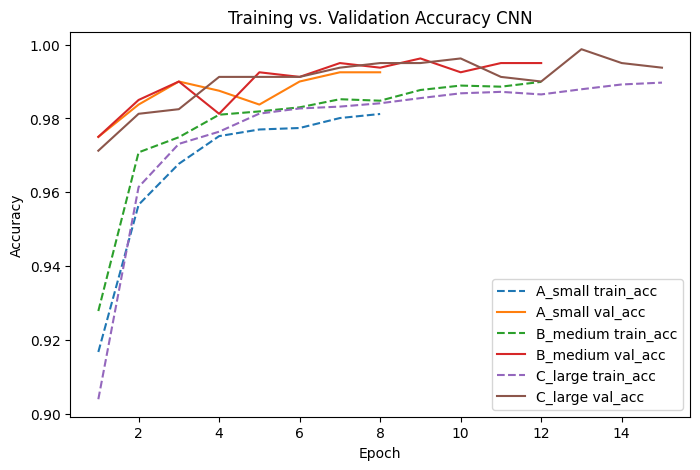

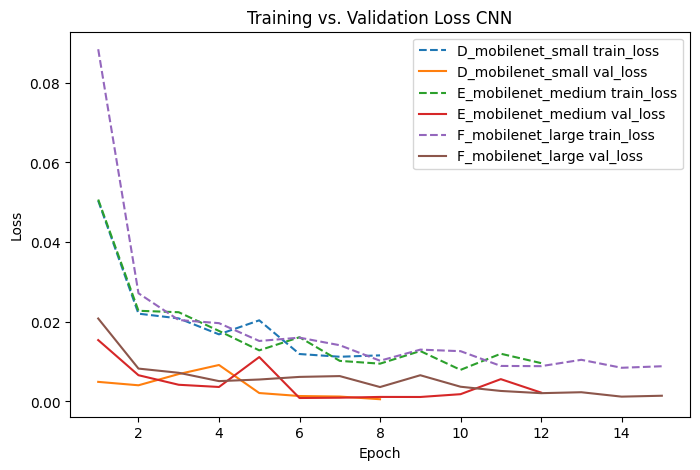

In [47]:
plt.figure(figsize=(8, 5))
for name, hist in histories_cnn.items():
    epochs = range(1, len(hist.history["accuracy"]) + 1)

    # -- Accuracy --
    plt.plot(epochs,
             hist.history["accuracy"],
             linestyle="--",  # gestrichelt = Training
             label=f"{name} train_acc")

    plt.plot(epochs,
             hist.history["val_accuracy"],
             label=f"{name} val_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy CNN")
plt.legend()
plt.show()

#  Loss-Kurven in einem separaten Plot
plt.figure(figsize=(8, 5))
for name, hist in histories_mobilenet.items():
    epochs = range(1, len(hist.history["loss"]) + 1)
    plt.plot(epochs, hist.history["loss"],
             linestyle="--",
             label=f"{name} train_loss")
    plt.plot(epochs, hist.history["val_loss"],
             label=f"{name} val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss CNN")
plt.legend()
plt.show()

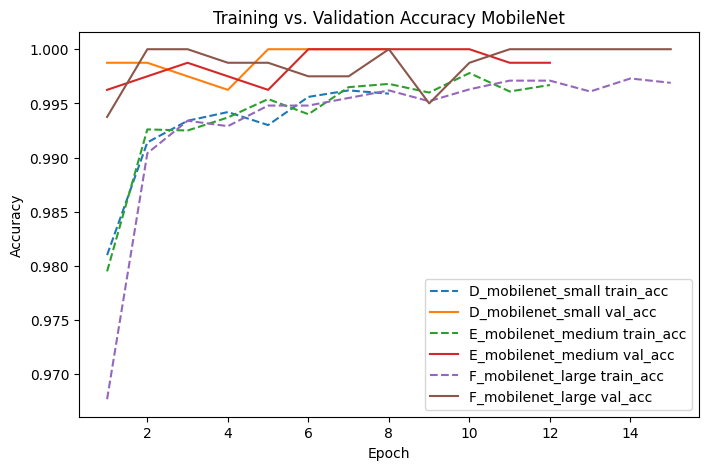

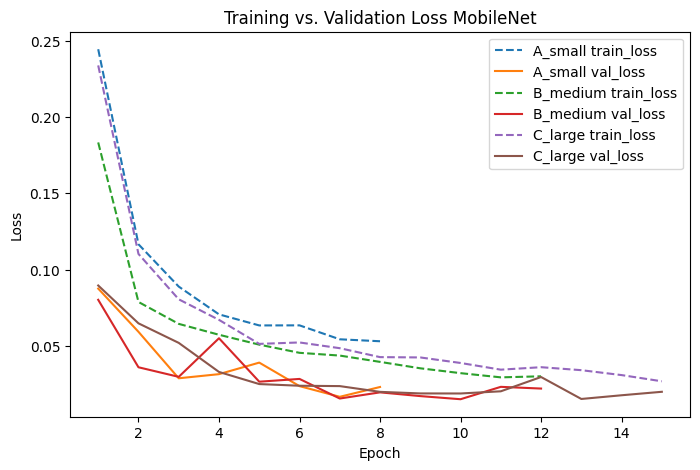

In [48]:
plt.figure(figsize=(8, 5))
for name, hist in histories_mobilenet.items():
    epochs = range(1, len(hist.history["accuracy"]) + 1)

    # -- Accuracy --
    plt.plot(epochs,
             hist.history["accuracy"],
             linestyle="--",  # gestrichelt = Training
             label=f"{name} train_acc")

    plt.plot(epochs,
             hist.history["val_accuracy"],
             label=f"{name} val_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy MobileNet")
plt.legend()
plt.show()

#  Loss-Kurven in einem separaten Plot
plt.figure(figsize=(8, 5))
for name, hist in histories_cnn.items():
    epochs = range(1, len(hist.history["loss"]) + 1)
    plt.plot(epochs, hist.history["loss"],
             linestyle="--",
             label=f"{name} train_loss")
    plt.plot(epochs, hist.history["val_loss"],
             label=f"{name} val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss MobileNet")
plt.legend()
plt.show()